In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nsidc_processor import GeotiffProcessor

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
north_geotiff_index = pd.read_csv('daily_northern_geotiff_index.csv', index_col=0)
north_geotiff_index.date = pd.to_datetime(north_geotiff_index.date, infer_datetime_format=True)

In [6]:
conc_index = north_geotiff_index.loc[north_geotiff_index.image_type == 'concentration']
ext_index = north_geotiff_index.loc[north_geotiff_index.image_type == 'extent']

In [7]:
conc_index = conc_index.set_index('date')
ext_index = ext_index.set_index('date')

In [8]:
conc_index.head()

,file_name,hemisphere,image_type
date,,,
1978-10-26,daily/geotiff/1978/N_19781026_concentration_v3...,north,concentration
1978-10-28,daily/geotiff/1978/N_19781028_concentration_v3...,north,concentration
1978-10-30,daily/geotiff/1978/N_19781030_concentration_v3...,north,concentration
1978-11-01,daily/geotiff/1978/N_19781101_concentration_v3...,north,concentration
1978-11-03,daily/geotiff/1978/N_19781103_concentration_v3...,north,concentration


In [9]:
ext_index.head()

,file_name,hemisphere,image_type
date,,,
1978-10-26,daily/geotiff/1978/N_19781026_extent_v3.0.tif,north,extent
1978-10-28,daily/geotiff/1978/N_19781028_extent_v3.0.tif,north,extent
1978-10-30,daily/geotiff/1978/N_19781030_extent_v3.0.tif,north,extent
1978-11-01,daily/geotiff/1978/N_19781101_extent_v3.0.tif,north,extent
1978-11-03,daily/geotiff/1978/N_19781103_extent_v3.0.tif,north,extent


In [10]:
conc_processor = GeotiffProcessor('raw_images/', conc_index)
ext_processor = GeotiffProcessor('raw_images/', ext_index)

In [11]:
conc_index_imputed = conc_processor.impute_missing_index_dates(set_this_index=True)
ext_index_imputed = ext_processor.impute_missing_index_dates(set_this_index=True)

----

In [12]:
ext_index_last_2 = conc_index_imputed.loc['2017-01-01':'2018-12-31']

In [13]:
ext_index_last_2

,file_name,hemisphere,image_type
date,,,
2017-01-01,daily/geotiff/2017/N_20170101_concentration_v3...,north,concentration
2017-01-02,daily/geotiff/2017/N_20170102_concentration_v3...,north,concentration
2017-01-03,daily/geotiff/2017/N_20170103_concentration_v3...,north,concentration
2017-01-04,daily/geotiff/2017/N_20170104_concentration_v3...,north,concentration
2017-01-05,daily/geotiff/2017/N_20170105_concentration_v3...,north,concentration
...,...,...,...
2018-12-27,daily/geotiff/2018/N_20181227_concentration_v3...,north,concentration
2018-12-28,daily/geotiff/2018/N_20181228_concentration_v3...,north,concentration
2018-12-29,daily/geotiff/2018/N_20181229_concentration_v3...,north,concentration


In [14]:
trim_processor = GeotiffProcessor('raw_images/', ext_index_last_2)

In [15]:
ext_last2 = trim_processor.process_images_keras_convlstm()

In [16]:
ext_last2.shape

(1, 730, 1, 448, 304)

In [15]:
from keras.models import Sequential
import keras.backend as k

def mean_power_error(y_true, y_pred, p):
    diff = k.abs(y_true - y_pred)
    powered = diff ** p
    return k.mean(powered)

Using TensorFlow backend.


In [85]:
seq = Sequential()
seq.add(ConvLSTM2D(
    filters=1,
    kernel_size=(3,3),
    input_shape=(None, 1, 448, 304),
    data_format='channels_first',
    return_sequences=True,
    activation='tanh',
    padding='same'))

In [86]:
seq.compile(loss=lambda true, pred: mean_power_error(true, pred, 4), optimizer='adadelta')

In [87]:
x_train = ext_last2[:,:365,:,:,:]
y_train = ext_last2[:,1:366,:,:,:]

In [88]:
seq.fit(x_train, y_train, epochs=2)

Epoch 1/2
1/1 [==============================] - 50s 50s/step - loss: 0.0054
Epoch 2/2
1/1 [==============================] - 50s 50s/step - loss: 0.0049


In [89]:
test_seq = ext_last2[:,10:30,:,:,:]

In [90]:
test_pred = seq.predict(test_seq)

In [91]:
test_frame = test_pred[:,15,:,:,:]

In [92]:
test_frame.shape

(1, 1, 448, 304)

In [16]:
trim_processor.load_default_colormaps('default_extent_colormap.pkl', 'default_concentration_colormap.pkl')

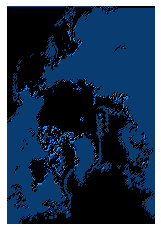

In [93]:
trim_processor.make_colored_prediction_image(test_frame, image_type='concentration')

In [20]:
trim_processor.image_index

,file_name,hemisphere,image_type
2017-01-01,daily/geotiff/2017/N_20170101_concentration_v3...,north,concentration
2017-01-02,daily/geotiff/2017/N_20170102_concentration_v3...,north,concentration
2017-01-03,daily/geotiff/2017/N_20170103_concentration_v3...,north,concentration
2017-01-04,daily/geotiff/2017/N_20170104_concentration_v3...,north,concentration
2017-01-05,daily/geotiff/2017/N_20170105_concentration_v3...,north,concentration
...,...,...,...
2018-12-27,daily/geotiff/2018/N_20181227_concentration_v3...,north,concentration
2018-12-28,daily/geotiff/2018/N_20181228_concentration_v3...,north,concentration
2018-12-29,daily/geotiff/2018/N_20181229_concentration_v3...,north,concentration
2018-12-30,daily/geotiff/2018/N_20181230_concentration_v3...,north,concentration


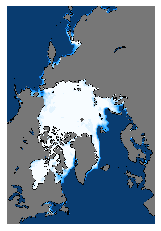

In [26]:
trim_processor.show_by_date('2018-01-01')

----

In [17]:
from keras.layers.convolutional import Conv2D
from keras.layers.recurrent import LSTM
from keras.layers import Flatten, Reshape, Permute
from keras.layers import TimeDistributed

In [18]:
conv_conc_images = trim_processor.process_images_keras_channels_first()

AttributeError: 'GeotiffProcessor' object has no attribute 'process_images_keras_conv2d'

In [245]:
x_train = conv_conc_images[:365,:,:,:]
y_train = conv_conc_images[1:366,:,:,:]

In [246]:
x_train.shape

(365, 1, 448, 304)

In [248]:
n_filters=4
seq2 = Sequential()
seq2.add(Conv2D(
    filters=n_filters,
    kernel_size=(5,5),
    strides=1,
    input_shape=(1, 448, 304),
    data_format='channels_first',
    activation='tanh',
    padding='same'))

In [249]:
seq2.compile(loss=lambda true, pred: mean_power_error(true, pred, 1), optimizer='adadelta')

In [250]:
seq2.fit(x_train, y_train, epochs=5)

Epoch 1/5
365/365 [==============================] - 16s 43ms/step - loss: 0.0661
Epoch 2/5
365/365 [==============================] - 16s 45ms/step - loss: 0.0408
Epoch 3/5
365/365 [==============================] - 17s 47ms/step - loss: 0.0235
Epoch 4/5
365/365 [==============================] - 19s 52ms/step - loss: 0.0170
Epoch 5/5
365/365 [==============================] - 21s 58ms/step - loss: 0.0162


In [252]:
test_frame = seq2.predict(conv_conc_images[365:730,:,:,:])

In [253]:
test_frame.shape

(365, 4, 448, 304)

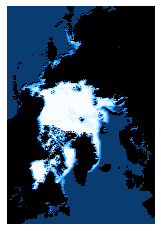

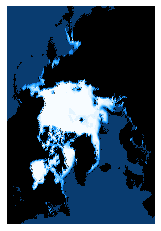

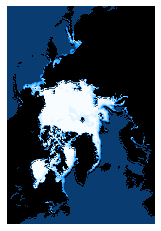

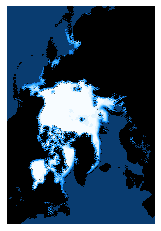

In [255]:
for i in range(seq2.output_shape[1]):
    frame = test_frame[-1,i,:,:]
    trim_processor.make_colored_prediction_image(frame, image_type='concentration').show()

----

In [19]:
lstm_images = trim_processor.process_images_keras_lstm()

In [20]:
lstm_images.shape

(1, 730, 136192)

In [21]:
x_train = lstm_images[:,:365,:]
y_train = lstm_images[:,1:366,:]

In [22]:
from keras.layers import Dense

In [23]:
lstm_seq = Sequential()
lstm_seq.add(LSTM(300, input_shape = (None, 136192), return_sequences=True))
lstm_seq.add(LSTM(300, input_shape = (None, 136192), return_sequences=True))
lstm_seq.add(LSTM(300, input_shape = (None, 136192), return_sequences=True))
lstm_seq.add(Dense(136192))

Instructions for updating:
Colocations handled automatically by placer.


In [24]:
lstm_seq.compile(loss='mean_squared_error', optimizer='adam')

In [25]:
lstm_seq.fit(x_train, y_train, use_multiprocessing=True)

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
1/1 [==============================] - 866s 866s/step - loss: 0.0187


In [26]:
x_train.shape

(1, 365, 136192)

In [27]:
test_frames = lstm_images[:,370:400,:]

In [28]:
test_preds = lstm_seq.predict(test_frames)

In [29]:
test_frame = test_frames[:,-1,:]
test_pred = test_preds[:,-1,:]

In [30]:
test_frame.shape

(1, 136192)

In [31]:
test_frame = test_frame.reshape(1, 448, 304)
test_pred = test_pred.reshape(1, 448, 304)

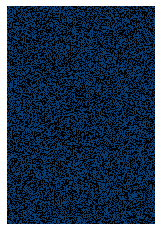

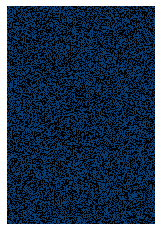

In [32]:
trim_processor.make_colored_prediction_image(test_pred, image_type='concentration')